# Standard Imports

In [2]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
from matplotlib import pylab
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import CPTAC.Endometrial as CPTAC

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list(). In order to access a specific data set,
import a CPTAC subfolder using either 'import CPTAC.Dataset' or 'from
CPTAC import Dataset'.
******
Version: 0.2.5
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


In [ ]:
def find_pvals(merged_df, bf):
    

In [147]:
# Function to return a dictionary of mutation comparison pvalues from different data locations
# parameters of function are perform_ttest(what kind of mutation comparison, dictionary to append, dataframe, and p-cutoff)
def perform_ttest(comp_type, pvals_dict, merged_df, bf):
    sig = True
    if comp_type == 'All':
        # Finding pvalues for the transcriptome
        t_mut = merged_df.loc[merged_df['Mutation_Type'] != 'Wildtype', 'Transcriptome']
        t_wt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome']
        t_tt = scipy.stats.ttest_ind(t_wt, t_mut)
        pvals_dict[comp_type + '_txn_pval'] = t_tt[1]
        # Finding pvalues for the proteome
        p_mut = merged_df.loc[merged_df['Mutation_Type'] != 'Wildtype', 'Proteome']
        p_wt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome']
        p_tt = scipy.stats.ttest_ind(p_wt, p_mut)
        pvals_dict[comp_type + '_prot_pval'] = p_tt[1]
    else:
        t_mut = merged_df.loc[merged_df['Mutation_Type'] == comp_type, 'Transcriptome']
        t_wt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome']
        t_tt = scipy.stats.ttest_ind(t_wt, t_mut)
        pvals_dict[comp_type + '_txn_pval'] = t_tt[1]
        # Finding pvalues for the proteome
        p_mut = merged_df.loc[merged_df['Mutation_Type'] == comp_type, 'Proteome']
        p_wt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome']
        p_tt = scipy.stats.ttest_ind(p_wt, p_mut)
        pvals_dict[comp_type + '_prot_pval'] = p_tt[1]
        
    if t_tt[1] <= bf and p_tt <= bf:
        pvals_dict[comp_type + '_Sig_In'] = 'Both'
    elif t_tt[1] <= bf and p_tt > bf:
        pvals_dict[comp_type + '_Sig_In'] = 'Transcriptome'
    elif t_tt[1] > bf and p_tt <= bf:
        pvals_dict[comp_type + '_Sig_In'] = 'Proteome'
    else:
        pvals_dict[comp_type + '_Sig_In'] = 'Neither'
        sig = False
    return pvals_dict, sig

In [ ]:
def create_df(final_df, protein, pvals_dict, merged_df)

### Designating CPTAC Variables

In [3]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
transcriptomics = CPTAC.get_transcriptomics()

### Designating a List of TP53 Hotspot Mutations Found in a Previous Analysis

In [4]:
# A list of mutations present in the hotspot according to our Hotspot3D output
gene = 'TP53'
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.241del','p.K164E', 'p.R249S', 'p.R273H', 'p.R282W','p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

In [144]:
shared_protein_list = list()
for protein in proteomics.columns:
    if protein in transcriptomics.columns:
        shared_protein_list.append(protein)

In [146]:
pcutoff = 0.05/len(shared_protein_list)
print('Our bonferroni p-cutoff value is ' + str(pcutoff))

Our bonferroni p-cutoff value is 4.551247041689423e-06


In [143]:
for protein in shared_protein_list:
    proteomics_df = CPTAC.compare_mutations(proteomics, protein, gene)
    proteomics_df.columns = ['Proteome', 'Mutation', 'Sample_Status']
    transcriptomics_df = CPTAC.compare_mutations(transcriptomics, protein, gene)
    transcriptomics_df.columns = ['Transcriptome', 'Mutation', 'Sample_Status']
    merged_data = proteomics_df.join(transcriptomics_df['Transcriptome'])
    merged_data.loc[merged_data['Sample_Status'] == 'Tumor', 'Mutation_Type'] = 'Non_Hotspot'
    merged_data.loc[hotspot_patients, 'Mutation_Type'] = 'Hotspot'
    merged_data.loc[merged_data['Mutation'] == 'Wildtype_Tumor', 'Mutation_Type'] = 'Wildtype'
    merged_data = merged_data.loc[merged_data['Sample_Status'] == 'Tumor'].dropna(axis=0)
    pvals_dict = find_pvals(merged_data, pcutoff)
    

SyntaxError: unexpected EOF while parsing (<ipython-input-143-b914773072e2>, line 2)

## All TP53 Mutations vs Wildtype Analysis

### Significant proteins that are significant in only one data set

In [89]:
# Creating a list for the unique correlations in all TP53 mutants vs wildtype analysis
all_mut_prot_array = np.array(all_prot_unique_list)
all_mut_tran_array = np.array(all_tran_unique_list) 
all_unique_array = np.concatenate((all_mut_prot_array, all_mut_tran_array))

In [117]:
# Creating dataframes for the unique proteins in all mutants vs wildtype for both the proteome and transcriptome
all_unique = pd.DataFrame({'Protein':all_unique_array})
all_unique = all_unique.set_index('Protein')
all_unique.loc[all_mut_prot_array, 'Sig_Loc'] = 'Proteomics'
all_unique.loc[all_mut_tran_array, 'Sig_Loc'] = 'Transcriptomics'
all_unique = all_unique.reset_index()

In [118]:
for protein in all_unique_array:
    proteome_data = CPTAC.compare_mutations(proteomics, protein, gene)
    transcriptome_data = CPTAC.compare_mutations(transcriptomics, protein, gene)
    # Renaming columns to relfect where the data is from (proteome or transcriptome) for the given protein
    proteome_data.columns = ['Proteome', 'Mutation', 'Sample_Status']
    transcriptome_data.columns = ['Transcriptome', 'Mutation', 'Sample_Status']
    all_data = proteome_data.join(transcriptome_data['Transcriptome'])
    all_data.loc[all_data['Sample_Status'] == 'Tumor', 'Mutation_Type'] = 'Non_Hotspot'
    all_data.loc[hotspot_patients, 'Mutation_Type'] = 'Hotspot'
    all_data.loc[all_data['Mutation'] == 'Wildtype_Tumor', 'Mutation_Type'] = 'Wildtype'
    all_data = all_data.loc[all_data['Sample_Status'] == 'Tumor'].dropna(axis=0)
    
    # Gathering mean value difference from the transcriptomics data
    t_mut_mean = all_data.loc[all_data['Mutation_Type'] != 'Wildtype', 'Transcriptome'].mean()
    t_wt_mean = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome'].mean()
    t_dif = t_wt_mean - t_mut_mean
    all_unique.loc[all_unique['Protein'] == protein, 'Transcriptome_Mean_Difference'] = t_dif
    # Gathering p-value from the transcriptomics data
    t_mut_tt = all_data.loc[all_data['Mutation_Type'] != 'Wildtype', 'Transcriptome']
    t_wt_tt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome']
    t_tt = scipy.stats.ttest_ind(t_wt_tt, t_mut_tt)
    all_unique.loc[all_unique['Protein'] == protein, 'Transcriptome_pvalue'] = np.log10(t_tt[1])*-1
    
    # Gathering mean value difference from the proteomics data
    p_mut_mean = all_data.loc[all_data['Mutation_Type'] != 'Wildtype', 'Proteome'].mean()
    p_wt_mean = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome'].mean()
    p_dif = p_wt_mean - p_mut_mean
    all_unique.loc[all_unique['Protein'] == protein, 'Proteome_Mean_Difference'] = p_dif
    #Gathering p-value from the proteomics data
    p_mut_tt = all_data.loc[all_data['Mutation_Type'] != 'Wildtype', 'Proteome']
    p_wt_tt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome']
    p_tt = scipy.stats.ttest_ind(p_wt_tt, p_mut_tt)
    all_unique.loc[all_unique['Protein'] == protein, 'Proteome_pvalue'] = np.log10(p_tt[1])*-1
    

### Significant proteins that are significant in both data sets

In [119]:
# Creating arrays for the shared correlations in both directions for TP53 mutants vs wildtype
 
all_shared_array = np.array(all_shared_list)

In [120]:
# Creating dataframes for the shared proteins in TP53 mutants vs wildtype between the proteome and transcriptome
all_shared = pd.DataFrame({'Protein':all_shared_array})

In [121]:
for protein in all_shared_array:
    proteome_data = CPTAC.compare_mutations(proteomics, protein, gene)
    transcriptome_data = CPTAC.compare_mutations(transcriptomics, protein, gene)
    # Renaming columns to relfect where the data is from (proteome or transcriptome) for the given protein
    proteome_data.columns = ['Proteome', 'Mutation', 'Sample_Status']
    transcriptome_data.columns = ['Transcriptome', 'Mutation', 'Sample_Status']
    all_data = proteome_data.join(transcriptome_data['Transcriptome'])
    all_data.loc[all_data['Sample_Status'] == 'Tumor', 'Mutation_Type'] = 'Non_Hotspot'
    all_data.loc[hotspot_patients, 'Mutation_Type'] = 'Hotspot'
    all_data.loc[all_data['Mutation'] == 'Wildtype_Tumor', 'Mutation_Type'] = 'Wildtype'
    all_data = all_data.loc[all_data['Sample_Status'] == 'Tumor'].dropna(axis=0)
    
    # Gathering mean value difference from the transcriptomics data
    t_mut_mean = all_data.loc[all_data['Mutation_Type'] != 'Wildtype', 'Transcriptome'].mean()
    t_wt_mean = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome'].mean()
    t_dif = t_wt_mean - t_mut_mean
    all_shared.loc[all_shared['Protein'] == protein, 'Transcriptome_Mean_Difference'] = t_dif
    # Gathering p-value from the transcriptomics data
    t_mut_tt = all_data.loc[all_data['Mutation_Type'] != 'Wildtype', 'Transcriptome']
    t_wt_tt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome']
    t_tt = scipy.stats.ttest_ind(t_wt_tt, t_mut_tt)
    all_shared.loc[all_shared['Protein'] == protein, 'Transcriptome_pvalue'] = np.log10(t_tt[1])*-1
    
    # Gathering mean value difference from the proteomics data
    p_mut_mean = all_data.loc[all_data['Mutation_Type'] != 'Wildtype', 'Proteome'].mean()
    p_wt_mean = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome'].mean()
    p_dif = p_wt_mean - p_mut_mean
    all_shared.loc[all_shared['Protein'] == protein, 'Proteome_Mean_Difference'] = p_dif
    #Gathering p-value from the proteomics data
    p_mut_tt = all_data.loc[all_data['Mutation_Type'] != 'Wildtype', 'Proteome']
    p_wt_tt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome']
    p_tt = scipy.stats.ttest_ind(p_wt_tt, p_mut_tt)
    all_shared.loc[all_shared['Protein'] == protein, 'Proteome_pvalue'] = np.log10(p_tt[1])*-1
    

### Scatter plot showing mean difference of transcriptome data (x-axis) vs. mean difference of proteome data (y-axis)

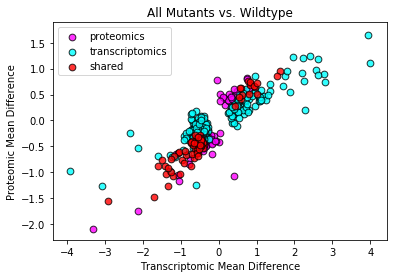

In [122]:
px = all_unique.loc[all_unique['Sig_Loc'] == 'Proteomics', 'Transcriptome_Mean_Difference']
py = all_unique.loc[all_unique['Sig_Loc'] == 'Proteomics', 'Proteome_Mean_Difference']
p_unique = (px, py)

tx = all_unique.loc[all_unique['Sig_Loc'] == 'Transcriptomics', 'Transcriptome_Mean_Difference']
ty = all_unique.loc[all_unique['Sig_Loc'] == 'Transcriptomics', 'Proteome_Mean_Difference']
t_unique = (tx, ty)

sx = all_shared['Transcriptome_Mean_Difference']
sy = all_shared['Proteome_Mean_Difference']
shared = (sx, sy)

xs = (px, tx, sx)
ys = (py, ty, sy)

data = (p_unique, t_unique, shared)
colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=45, label=group)
    
plt.title('All Mutants vs. Wildtype')
plt.legend(loc=2)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()

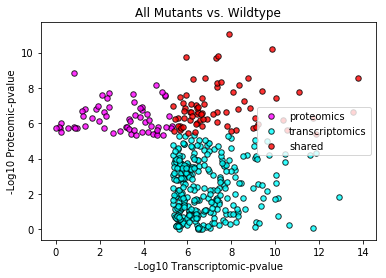

In [123]:
px = all_unique.loc[all_unique['Sig_Loc'] == 'Proteomics', 'Transcriptome_pvalue']
py = all_unique.loc[all_unique['Sig_Loc'] == 'Proteomics', 'Proteome_pvalue']
p_unique = (px, py)

tx = all_unique.loc[all_unique['Sig_Loc'] == 'Transcriptomics', 'Transcriptome_pvalue']
ty = all_unique.loc[all_unique['Sig_Loc'] == 'Transcriptomics', 'Proteome_pvalue']
t_unique = (tx, ty)

sx = all_shared['Transcriptome_pvalue']
sy = all_shared['Proteome_pvalue']
shared = (sx, sy)

xs = (px, tx, sx)
ys = (py, ty, sy)

data = (p_unique, t_unique, shared)
colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('All Mutants vs. Wildtype')
plt.legend(loc=5)
plt.xlabel("-Log10 Transcriptomic-pvalue")
plt.ylabel("-Log10 Proteomic-pvalue")
plt.show()

## Hotspot TP53 Mutations vs Wildtype Analysis

### Significant proteins that are significant in only one data set

In [124]:
# Creating a list for the unique correlations in TP53 hotspot mutants vs wildtype analysis
hotspot_mut_prot_array = np.array(hotspot_prot_unique_list)
hotspot_mut_tran_array = np.array(hotspot_tran_unique_list)
hotspot_unique_array = np.concatenate((hotspot_mut_prot_array, hotspot_mut_tran_array))

In [125]:
# Creating dataframes for the unique proteins in hotspot mutants vs wildtype for both the proteome and transcriptome
hotspot_unique = pd.DataFrame({'Protein':hotspot_unique_array})
hotspot_unique = hotspot_unique.set_index('Protein')
hotspot_unique.loc[hotspot_mut_prot_array, 'Sig_Loc'] = 'Proteomics'
hotspot_unique.loc[hotspot_mut_tran_array, 'Sig_Loc'] = 'Transcriptomics'
hotspot_unique = hotspot_unique.reset_index()

In [126]:
for protein in hotspot_unique_array:
    proteome_data = CPTAC.compare_mutations(proteomics, protein, gene)
    transcriptome_data = CPTAC.compare_mutations(transcriptomics, protein, gene)
    # Renaming columns to relfect where the data is from (proteome or transcriptome) for the given protein
    proteome_data.columns = ['Proteome', 'Mutation', 'Sample_Status']
    transcriptome_data.columns = ['Transcriptome', 'Mutation', 'Sample_Status']
    all_data = proteome_data.join(transcriptome_data['Transcriptome'])
    all_data.loc[all_data['Sample_Status'] == 'Tumor', 'Mutation_Type'] = 'Non_Hotspot'
    all_data.loc[hotspot_patients, 'Mutation_Type'] = 'Hotspot'
    all_data.loc[all_data['Mutation'] == 'Wildtype_Tumor', 'Mutation_Type'] = 'Wildtype'
    all_data = all_data.loc[all_data['Sample_Status'] == 'Tumor'].dropna(axis=0)
    
    # Gathering mean value difference from the transcriptomics data
    t_mut_mean = all_data.loc[all_data['Mutation_Type'] == 'Hotspot', 'Transcriptome'].mean()
    t_wt_mean = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome'].mean()
    t_dif = t_wt_mean - t_mut_mean
    hotspot_unique.loc[hotspot_unique['Protein'] == protein, 'Transcriptome_Mean_Difference'] = t_dif
    # Gathering p-value from the transcriptomics data
    t_mut_tt = all_data.loc[all_data['Mutation_Type'] == 'Hotspot', 'Transcriptome']
    t_wt_tt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome']
    t_tt = scipy.stats.ttest_ind(t_wt_tt, t_mut_tt)
    hotspot_unique.loc[hotspot_unique['Protein'] == protein, 'Transcriptome_pvalue'] = np.log10(t_tt[1])*-1
    
    # Gathering mean value difference from the proteomics data
    p_mut_mean = all_data.loc[all_data['Mutation_Type'] == 'Hotspot', 'Proteome'].mean()
    p_wt_mean = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome'].mean()
    p_dif = p_wt_mean - p_mut_mean
    hotspot_unique.loc[hotspot_unique['Protein'] == protein, 'Proteome_Mean_Difference'] = p_dif
    #Gathering p-value from the proteomics data
    p_mut_tt = all_data.loc[all_data['Mutation_Type'] == 'Hotspot', 'Proteome']
    p_wt_tt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome']
    p_tt = scipy.stats.ttest_ind(p_wt_tt, p_mut_tt)
    hotspot_unique.loc[hotspot_unique['Protein'] == protein, 'Proteome_pvalue'] = np.log10(p_tt[1])*-1
    

### Significant proteins that are significant in both data sets

In [127]:
#Creating arrays for the shared correlations in both directions for TP53 hotspot mutants vs wildtype    
hotspot_shared_array = np.array(hotspot_shared_list)

In [128]:
# Creating dataframes for the shared proteins in TP53 mutants vs wildtype between the proteome and transcriptome
hotspot_shared = pd.DataFrame({'Protein':hotspot_shared_array})


In [129]:
for protein in hotspot_shared_array:
    proteome_data = CPTAC.compare_mutations(proteomics, protein, gene)
    transcriptome_data = CPTAC.compare_mutations(transcriptomics, protein, gene)
    # Renaming columns to relfect where the data is from (proteome or transcriptome) for the given protein
    proteome_data.columns = ['Proteome', 'Mutation', 'Sample_Status']
    transcriptome_data.columns = ['Transcriptome', 'Mutation', 'Sample_Status']
    all_data = proteome_data.join(transcriptome_data['Transcriptome'])
    all_data.loc[all_data['Sample_Status'] == 'Tumor', 'Mutation_Type'] = 'Non_Hotspot'
    all_data.loc[hotspot_patients, 'Mutation_Type'] = 'Hotspot'
    all_data.loc[all_data['Mutation'] == 'Wildtype_Tumor', 'Mutation_Type'] = 'Wildtype'
    all_data = all_data.loc[all_data['Sample_Status'] == 'Tumor'].dropna(axis=0)
    
    # Gathering mean value difference from the transcriptomics data
    t_mut_mean = all_data.loc[all_data['Mutation_Type'] == 'Hotspot', 'Transcriptome'].mean()
    t_wt_mean = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome'].mean()
    t_dif = t_wt_mean - t_mut_mean
    hotspot_shared.loc[hotspot_shared['Protein'] == protein, 'Transcriptome_Mean_Difference'] = t_dif
    # Gathering p-value from the transcriptomics data
    t_mut_tt = all_data.loc[all_data['Mutation_Type'] == 'Hotspot', 'Transcriptome']
    t_wt_tt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome']
    t_tt = scipy.stats.ttest_ind(t_wt_tt, t_mut_tt)
    hotspot_shared.loc[hotspot_shared['Protein'] == protein, 'Transcriptome_pvalue'] = np.log10(t_tt[1])*-1
    
    # Gathering mean value difference from the proteomics data
    p_mut_mean = all_data.loc[all_data['Mutation_Type'] == 'Hotspot', 'Proteome'].mean()
    p_wt_mean = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome'].mean()
    p_dif = p_wt_mean - p_mut_mean
    hotspot_shared.loc[hotspot_shared['Protein'] == protein, 'Proteome_Mean_Difference'] = p_dif
    #Gathering p-value from the proteomics data
    p_mut_tt = all_data.loc[all_data['Mutation_Type'] == 'Hotspot', 'Proteome']
    p_wt_tt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome']
    p_tt = scipy.stats.ttest_ind(p_wt_tt, p_mut_tt)
    hotspot_shared.loc[hotspot_shared['Protein'] == protein, 'Proteome_pvalue'] = np.log10(p_tt[1])*-1
    

### Scatter plot showing mean difference of transcriptome data (x-axis) vs. mean difference of proteome data (y-axis)

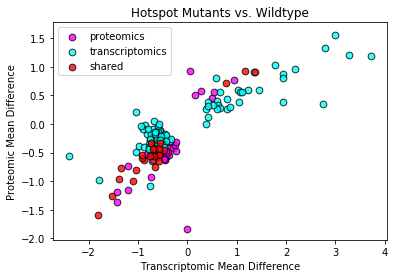

In [130]:
px = hotspot_unique.loc[hotspot_unique['Sig_Loc'] == 'Proteomics', 'Transcriptome_Mean_Difference']
py = hotspot_unique.loc[hotspot_unique['Sig_Loc'] == 'Proteomics', 'Proteome_Mean_Difference']
p_unique = (px, py)

tx = hotspot_unique.loc[hotspot_unique['Sig_Loc'] == 'Transcriptomics', 'Transcriptome_Mean_Difference']
ty = hotspot_unique.loc[hotspot_unique['Sig_Loc'] == 'Transcriptomics', 'Proteome_Mean_Difference']
t_unique = (tx, ty)

sx = hotspot_shared['Transcriptome_Mean_Difference']
sy = hotspot_shared['Proteome_Mean_Difference']
shared = (sx, sy)

xs = (px, tx, sx)
ys = (py, ty, sy)

data = (p_unique, t_unique, shared)
colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=45, label=group)
    
plt.title('Hotspot Mutants vs. Wildtype')
plt.legend(loc=2)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()

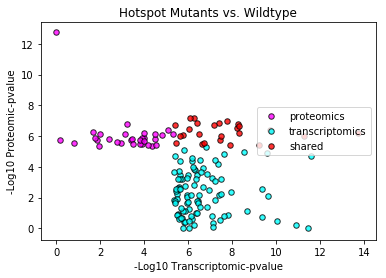

In [131]:
px = hotspot_unique.loc[hotspot_unique['Sig_Loc'] == 'Proteomics', 'Transcriptome_pvalue']
py = hotspot_unique.loc[hotspot_unique['Sig_Loc'] == 'Proteomics', 'Proteome_pvalue']
p_unique = (px, py)

tx = hotspot_unique.loc[hotspot_unique['Sig_Loc'] == 'Transcriptomics', 'Transcriptome_pvalue']
ty = hotspot_unique.loc[hotspot_unique['Sig_Loc'] == 'Transcriptomics', 'Proteome_pvalue']
t_unique = (tx, ty)

sx = hotspot_shared['Transcriptome_pvalue']
sy = hotspot_shared['Proteome_pvalue']
shared = (sx, sy)

xs = (px, tx, sx)
ys = (py, ty, sy)

data = (p_unique, t_unique, shared)
colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Hotspot Mutants vs. Wildtype')
plt.legend(loc=5)
plt.xlabel("-Log10 Transcriptomic-pvalue")
plt.ylabel("-Log10 Proteomic-pvalue")
plt.show()

## Non-Hotspot TP53 Mutations vs Wildtype Analysis

### Significant proteins that are significant in only one data set


In [132]:
# Creating a list for the unique correlations in TP53 non-nonhs mutants vs wildtype analysis
nonhs_mut_prot_array = np.array(nonhs_prot_unique_list)
nonhs_mut_tran_array = np.array(nonhs_tran_unique_list)
nonhs_unique_array = np.concatenate((nonhs_mut_prot_array, nonhs_mut_tran_array))

In [133]:
# Creating dataframes for the unique proteins in nonhs mutants vs wildtype for both the proteome and transcriptome
nonhs_unique = pd.DataFrame({'Protein':nonhs_unique_array})
nonhs_unique = nonhs_unique.set_index('Protein')
nonhs_unique.loc[nonhs_mut_prot_array, 'Sig_Loc'] = 'Proteomics'
nonhs_unique.loc[nonhs_mut_tran_array, 'Sig_Loc'] = 'Transcriptomics'
nonhs_unique = nonhs_unique.reset_index()

In [134]:
for protein in nonhs_unique_array:
    proteome_data = CPTAC.compare_mutations(proteomics, protein, gene)
    transcriptome_data = CPTAC.compare_mutations(transcriptomics, protein, gene)
    # Renaming columns to relfect where the data is from (proteome or transcriptome) for the given protein
    proteome_data.columns = ['Proteome', 'Mutation', 'Sample_Status']
    transcriptome_data.columns = ['Transcriptome', 'Mutation', 'Sample_Status']
    all_data = proteome_data.join(transcriptome_data['Transcriptome'])
    all_data.loc[all_data['Sample_Status'] == 'Tumor', 'Mutation_Type'] = 'Non_Hotspot'
    all_data.loc[hotspot_patients, 'Mutation_Type'] = 'Hotspot'
    all_data.loc[all_data['Mutation'] == 'Wildtype_Tumor', 'Mutation_Type'] = 'Wildtype'
    all_data = all_data.loc[all_data['Sample_Status'] == 'Tumor'].dropna(axis=0)
    
    # Gathering mean value difference from the transcriptomics data
    t_mut_mean = all_data.loc[all_data['Mutation_Type'] == 'Non_Hotspot', 'Transcriptome'].mean()
    t_wt_mean = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome'].mean()
    t_dif = t_wt_mean - t_mut_mean
    nonhs_unique.loc[nonhs_unique['Protein'] == protein, 'Transcriptome_Mean_Difference'] = t_dif
    # Gathering p-value from the transcriptomics data
    t_mut_tt = all_data.loc[all_data['Mutation_Type'] == 'Non_Hotspot', 'Transcriptome']
    t_wt_tt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome']
    t_tt = scipy.stats.ttest_ind(t_wt_tt, t_mut_tt)
    nonhs_unique.loc[nonhs_unique['Protein'] == protein, 'Transcriptome_pvalue'] = np.log10(t_tt[1])*-1
    
    # Gathering mean value difference from the proteomics data
    p_mut_mean = all_data.loc[all_data['Mutation_Type'] == 'Non_Hotspot', 'Proteome'].mean()
    p_wt_mean = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome'].mean()
    p_dif = p_wt_mean - p_mut_mean
    nonhs_unique.loc[nonhs_unique['Protein'] == protein, 'Proteome_Mean_Difference'] = p_dif
    #Gathering p-value from the proteomics data
    p_mut_tt = all_data.loc[all_data['Mutation_Type'] == 'Non_Hotspot', 'Proteome']
    p_wt_tt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome']
    p_tt = scipy.stats.ttest_ind(p_wt_tt, p_mut_tt)
    nonhs_unique.loc[nonhs_unique['Protein'] == protein, 'Proteome_pvalue'] = np.log10(p_tt[1])*-1

### Significant proteins that are significant in both data sets

In [135]:
# Creating arrays for the shared correlations in both directions for TP53 non-nonhs mutants vs wildtype
nonhs_mut_shared_pos_array = np.array(['CDKAL1', 'LSG1', 'STAT2'])
nonhs_mut_shared_neg_array = np.array(['KIF13B', 'SNX7', 'VPS13C'])

nonhs_mut_shared_pos_list = list()
for protein in nonhs_mut_shared_pos_array:
    if protein in proteomics.columns and protein in transcriptomics.columns:
        nonhs_mut_shared_pos_list.append(protein)
    nonhs_mut_shared_pos_array = np.array(nonhs_mut_shared_pos_list)
    
nonhs_mut_shared_neg_list = list()
for protein in nonhs_mut_shared_neg_array:
    if protein in proteomics.columns and protein in transcriptomics.columns:
        nonhs_mut_shared_neg_list.append(protein)
    nonhs_mut_shared_neg_array = np.array(nonhs_mut_shared_neg_list)
    
nonhs_shared_array = np.concatenate((nonhs_mut_shared_pos_array, nonhs_mut_shared_neg_array))

In [136]:
# Creating dataframes for the shared proteins in TP53 mutants vs wildtype between the proteome and transcriptome
nonhs_shared = pd.DataFrame({'Protein':nonhs_shared_array})
nonhs_shared = nonhs_shared.set_index('Protein')
nonhs_shared.loc[nonhs_mut_shared_pos_array, 'Direction'] = 'Positive'
nonhs_shared.loc[nonhs_mut_shared_neg_array, 'Direction'] = 'Negative'
nonhs_shared = nonhs_shared.reset_index()

In [137]:
for protein in nonhs_shared_array:
    proteome_data = CPTAC.compare_mutations(proteomics, protein, gene)
    transcriptome_data = CPTAC.compare_mutations(transcriptomics, protein, gene)
    # Renaming columns to relfect where the data is from (proteome or transcriptome) for the given protein
    proteome_data.columns = ['Proteome', 'Mutation', 'Sample_Status']
    transcriptome_data.columns = ['Transcriptome', 'Mutation', 'Sample_Status']
    all_data = proteome_data.join(transcriptome_data['Transcriptome'])
    all_data.loc[all_data['Sample_Status'] == 'Tumor', 'Mutation_Type'] = 'Non_Hotspot'
    all_data.loc[hotspot_patients, 'Mutation_Type'] = 'Hotspot'
    all_data.loc[all_data['Mutation'] == 'Wildtype_Tumor', 'Mutation_Type'] = 'Wildtype'
    all_data = all_data.loc[all_data['Sample_Status'] == 'Tumor'].dropna(axis=0)
    
    # Gathering mean value difference from the transcriptomics data
    t_mut_mean = all_data.loc[all_data['Mutation_Type'] == 'Non_Hotspot', 'Transcriptome'].mean()
    t_wt_mean = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome'].mean()
    t_dif = t_wt_mean - t_mut_mean
    nonhs_shared.loc[nonhs_shared['Protein'] == protein, 'Transcriptome_Mean_Difference'] = t_dif
    # Gathering p-value from the transcriptomics data
    t_mut_tt = all_data.loc[all_data['Mutation_Type'] == 'Non_Hotspot', 'Transcriptome']
    t_wt_tt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Transcriptome']
    t_tt = scipy.stats.ttest_ind(t_wt_tt, t_mut_tt)
    nonhs_shared.loc[nonhs_shared['Protein'] == protein, 'Transcriptome_pvalue'] = np.log10(t_tt[1])*-1
    
    # Gathering mean value difference from the proteomics data
    p_mut_mean = all_data.loc[all_data['Mutation_Type'] == 'Non_Hotspot', 'Proteome'].mean()
    p_wt_mean = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome'].mean()
    p_dif = p_wt_mean - p_mut_mean
    nonhs_shared.loc[nonhs_shared['Protein'] == protein, 'Proteome_Mean_Difference'] = p_dif
    #Gathering p-value from the proteomics data
    p_mut_tt = all_data.loc[all_data['Mutation_Type'] == 'Non_Hotspot', 'Proteome']
    p_wt_tt = all_data.loc[all_data['Mutation_Type'] == 'Wildtype', 'Proteome']
    p_tt = scipy.stats.ttest_ind(p_wt_tt, p_mut_tt)
    nonhs_shared.loc[nonhs_shared['Protein'] == protein, 'Proteome_pvalue'] = np.log10(p_tt[1])*-1
    

### Scatter plot showing mean difference of transcriptome data (x-axis) vs. mean difference of proteome data (y-axis)

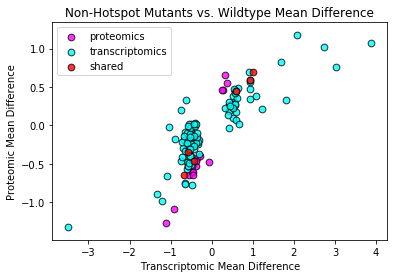

In [138]:
px = nonhs_unique.loc[nonhs_unique['Sig_Loc'] == 'Proteomics', 'Transcriptome_Mean_Difference']
py = nonhs_unique.loc[nonhs_unique['Sig_Loc'] == 'Proteomics', 'Proteome_Mean_Difference']
p_unique = (px, py)

tx = nonhs_unique.loc[nonhs_unique['Sig_Loc'] == 'Transcriptomics', 'Transcriptome_Mean_Difference']
ty = nonhs_unique.loc[nonhs_unique['Sig_Loc'] == 'Transcriptomics', 'Proteome_Mean_Difference']
t_unique = (tx, ty)

sx = nonhs_shared['Transcriptome_Mean_Difference']
sy = nonhs_shared['Proteome_Mean_Difference']
shared = (sx, sy)

xs = (px, tx, sx)
ys = (py, ty, sy)

data = (p_unique, t_unique, shared)
colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=45, label=group)
    
plt.title('Non-Hotspot Mutants vs. Wildtype Mean Difference')
plt.legend(loc=2)
plt.xlabel("Transcriptomic Mean Difference")
plt.ylabel("Proteomic Mean Difference")
plt.show()

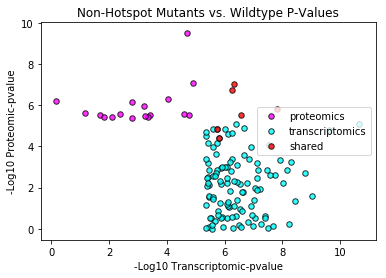

In [139]:
px = nonhs_unique.loc[nonhs_unique['Sig_Loc'] == 'Proteomics', 'Transcriptome_pvalue']
py = nonhs_unique.loc[nonhs_unique['Sig_Loc'] == 'Proteomics', 'Proteome_pvalue']
p_unique = (px, py)

tx = nonhs_unique.loc[nonhs_unique['Sig_Loc'] == 'Transcriptomics', 'Transcriptome_pvalue']
ty = nonhs_unique.loc[nonhs_unique['Sig_Loc'] == 'Transcriptomics', 'Proteome_pvalue']
t_unique = (tx, ty)

sx = nonhs_shared['Transcriptome_pvalue']
sy = nonhs_shared['Proteome_pvalue']
shared = (sx, sy)

xs = (px, tx, sx)
ys = (py, ty, sy)

data = (p_unique, t_unique, shared)
colors = ('magenta', 'cyan', 'red')
groups = ('proteomics', 'transcriptomics', 'shared')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
 
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='black', s=30, label=group)
    
plt.title('Non-Hotspot Mutants vs. Wildtype P-Values')
plt.legend(loc=5)
plt.xlabel("-Log10 Transcriptomic-pvalue")
plt.ylabel("-Log10 Proteomic-pvalue")
plt.show()